### **EJEMPLO 1**
### Modelo Integrador (hardcodeado)

In [1]:
from docplex.cp.model import *
import docplex.cp.utils_visu as visu

# unidades requeridas

nec = {
    'VEZMU1EQ': 34,
    'QTROUV79': 23,
    'YUIIIP4W': 20,
}

# tiempos (en minutos) de los procesos por producto

prod = {
    'VEZMU1EQ': 
    {
    'corte_m': 48,
    'doblado': 38,
    'soldado': 56,
    'corte_w': 0,
    'tapizado': 0,
    'pintura': 36,      # ROJO
    'despacho': 20
    },
    'QTROUV79': 
    {
    'corte_m': 45,
    'doblado': 23,
    'soldado': 32,
    'corte_w': 34,
    'tapizado': 102,
    'pintura': 36,      # ALUMINIO
    'despacho': 34
    },
    'YUIIIP4W': 
    {
    'corte_m': 0,
    'doblado': 0,
    'soldado': 0,
    'corte_w': 23,
    'tapizado': 0,
    'pintura': 15,      # LACA
    'despacho': 24
    }
}

# cantidad de operarios por área

operarios = {
    'corte_m': 2,
    'doblado': 1,
    'soldado': 2,
    'corte_w': 2,
    'tapizado':1,
    'pintura': 1,
    'despacho': 3
}

# operaciones 

op = ['corte_m','doblado','soldado','corte_w','tapizado','pintura','despacho']

ultima_op = 'despacho'

# definicion de calendario ******

dic = CpoStepFunction()

horizonte = 500*24 # (en horas ... 500 días)

dic.set_value(0, horizonte, 0)          # carga 1000 horas todas al 0%

s = 0
for j in range(0, horizonte, 24):
    if s<5:
        for k in range(j+8, j+17):
            dic.set_value(k, k+1, 100)
        dic.set_value(j+12, j+13, 0)    # almuerzo
    s = s + 1
    if s == 7: s = 0

colores = ['laca', 'blanco', 'crema', 'marrón', 'dorado', 'rojo', 'aluminio', 'negro']

color_tipos = [5, 6, 0]

m_color = [ [25, 25, 25, 25, 25, 25, 25, 25],
            [50, 25, 30, 30, 30, 30, 30, 30],
            [50, 40, 25, 30, 30, 30, 30, 30],
            [50, 50, 50, 25, 30, 50, 50, 30],
            [50, 50, 50, 30, 25, 50, 30, 30],
            [50, 50, 50, 40, 50, 25, 50, 30],
            [50, 50, 40, 40, 40, 50, 25, 25],
            [50, 50, 50, 50, 50, 50, 50, 25]]

matriz_color = transition_matrix(m_color)

# colores para el diagrama de gantt

color_gantt = ['lightblue','yellow','orange','lightcoral','lightgrey','lightgreen','lightcyan']


 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Minimization problem - 22 variables, 26 constraints
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 92.2 (before), 92.2 (after)
 !  . Memory usage      : 678.6 kB (before), 678.6 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         22                 -
 + New bound is 443
 ! Using iterative diving.
 *           567       43  0.02s        1      (gap is 21.87%)
             567       44         22    1   F        -
 + New bound is 567 (gap is 0.00%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! Best objective         : 567 (optimal - effective tol. is 0)
 ! Best bound             : 567
 ! --------------------

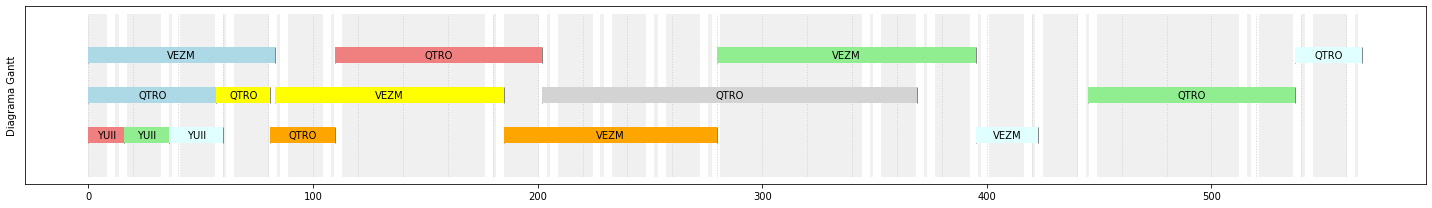

In [3]:
m = CpoModel()

ope = []

# declaracion de intervalos

for i in nec:
    r = []
    for j in op:        
        r.append(m.interval_var(size = int((prod[i][j]*nec[i])/60), name = j + '_' + i, intensity=dic))    # pasaje a horas e inclusión de intensity ******
    ope.append(r)

# relaciones de precedencia

for i in range(len(nec)):
    for j in range(len(op)-1):
        m.add(m.end_before_start(ope[i][j], ope[i][j+1]))

# restriccion de cantidad de operarios

for j in op:
    m.add(
        m.sum(
            m.pulse(ope[i][op.index(j)],1) for i in range(len(nec)) ) <= operarios[j]
            
        )
    
# secuencia de pintura 

seq_pintura = m.sequence_var([ope[i][5] for i in range(len(nec))], name='secuencia_pintura', types = color_tipos)

m.add(m.no_overlap(seq_pintura, matriz_color, True))

# funcional

m.add( m.minimize(m.max(m.end_of(ope[i][op.index(ultima_op)]) for i in range(len(nec)))))

s = m.solve()

s.print_solution()

# diagrama de gantt

from pylab import rcParams
rcParams['figure.figsize'] = 20, 3


visu.panel(name='Diagrama Gantt')
visu.pause(dic) # ****** inclusión del calendario en el gráfico
visu.naming(lambda name: name[0:4])  
if s:
    for i in nec:
        for j in op:
            if s.get_var_solution(j + '_' + i).size>0:
                visu.interval(s.get_var_solution(j + '_' + i), color_gantt[op.index(j)], i)        

visu.show(horizon=200, origin=100)